In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2023-07-01 11:06:04.063340: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-01 11:06:04.065587: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-01 11:06:04.132960: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-01 11:06:04.133814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 11:06:05.157492: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 8

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
Total params: 1,158
Trainable params: 1,158
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
51/70 [====================>.........] - ETA: 0s - loss: 2.0815 - accuracy: 0.2089
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
70/70 [==============================] - 1s 6ms/step - loss: 2.0543 - accuracy: 0.2250 - val_loss: 1.9383 - val_accuracy: 0.2946
Epoch 2/1000
58/70 [=======================>......] - ETA: 0s - loss: 1.9296 - accuracy: 0.2698
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 1.9207 - accuracy: 0.2733 - val_loss: 1.8294 - val_accuracy: 0.3100
Epoch 3/1000
46/70 [==================>...........] - ETA: 0s - loss: 1.8554 - accuracy: 0.3028
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 1.8404 - accuracy: 0.3086 - val_loss: 1.7280 - val_accuracy: 0.3529
Epoch 4/1000
61/70 [=========================>....] - ETA: 0s - loss: 1.7645 - accuracy: 0.3253
E

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

24/24 [==============================] - 0s 590us/step - loss: 0.4935 - accuracy: 0.8753


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 46ms/step
[1.8480700e-03 1.4189841e-01 5.0505962e-02 3.0278792e-03 3.8307474e-04
 5.7478057e-05 1.4283782e-03 8.0085075e-01]
7


# Confusion matrix

94/94 [==============================] - 0s 449us/step


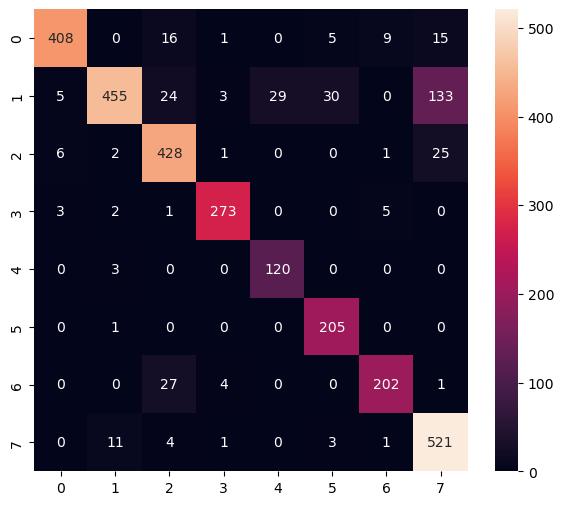

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       454
           1       0.96      0.67      0.79       679
           2       0.86      0.92      0.89       463
           3       0.96      0.96      0.96       284
           4       0.81      0.98      0.88       123
           5       0.84      1.00      0.91       206
           6       0.93      0.86      0.89       234
           7       0.75      0.96      0.84       541

    accuracy                           0.88      2984
   macro avg       0.88      0.91      0.89      2984
weighted avg       0.89      0.88      0.87      2984



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2023-07-01 11:06:46.068291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,42]
	 [[{{node input_1}}]]
2023-07-01 11:06:46.103769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,42]
	 [[{{node inputs}}]]
2023-07-01 11:06:46.111577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,42]
	 [[{{node input_1}}]]
2023-07-01 11:0

INFO:tensorflow:Assets written to: /tmp/tmpgfu2axrh/assets


INFO:tensorflow:Assets written to: /tmp/tmpgfu2axrh/assets
2023-07-01 11:06:46.716716: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-01 11:06:46.716751: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-01 11:06:46.717777: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgfu2axrh
2023-07-01 11:06:46.718529: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-01 11:06:46.718547: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgfu2axrh
2023-07-01 11:06:46.721314: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-07-01 11:06:46.721951: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-07-01 11:06:46.750986: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

6720

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 0 ns, sys: 197 µs, total: 197 µs
Wall time: 134 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.8480690e-03 1.4189842e-01 5.0505951e-02 3.0278789e-03 3.8307474e-04
 5.7478057e-05 1.4283782e-03 8.0085075e-01]
7
